# **Банки - Сегментация пользователей по потреблению.**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Ссылка на презентацию: https://disk.yandex.ru/i/jeqTzk9RTtYdwA

**Цель:**

Проанализируйте клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

***Датасет bank_dataset.csv содержит колонки:***

-userid — идентификатор пользователя,

-score — баллы кредитного скоринга,

-City — город,

-Gender — пол,

-Age — возраст,

-Objects — количество объектов в собственности,

-Balance — баланс на счёте,

-Products — количество продуктов, которыми пользуется клиент,

-CreditCard — есть ли кредитная карта,

-Loyalty — активный клиент,

-estimated_salary — заработная плата клиента,

-Churn — ушёл или нет.

**Декомпозиция**

1.Предобработка данных

      1.1  Проверим датасета на наличие дубликатов, пропусков и ошибок

        1.1.1  Приведём названия столбцов к нижнему регистру
        1.1.2  Проверим соответствие типов данных
        1.1.3  Проверим наличие пропусков
        1.1.4  Проверим на дубликаты
        
2.Исследовательский анализ (EDA)

      2.1  Разделим клиентов на кагорты
        2.1.1  Построим график количества клиентов в каждой кагорте
      2.2  Средние значения признаков в кагортах
      2.3  Столбчатые гистограммы и распределения признаков в кагортах
      2.4  Mатрица корреляций
      
3.Сегментировать пользователей по количеству потребляемых продуктов

     3.1 Сравним кластеры по средним значениям имеющихся метрик
     3.2 График среднего кредитного рейтинга клиента по сегментам 
     
4.Проверить статистические гипотезы

     4.1 Проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.
     4.2 Сформулировать и проверить статистическую гипотезу относительно представленных данных.
     
5.Выводы

### Предобработка данных

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score
from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
filterwarnings("ignore")

In [113]:
import warnings
warnings.filterwarnings('ignore')

In [114]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(rc={'figure.figsize':(10,5)})

In [115]:
df = pd.read_csv('/datasets/bank_dataset.csv')

In [116]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
userid,15677338,15690047,15662040,15744090,15780624,15616748,15635267,15698884,15835101,15635125
score,619,608,502,699,850,645,822,376,501,684
City,Ярославль,Рыбинск,Ярославль,Ярославль,Рыбинск,Рыбинск,Ярославль,Ростов Великий,Ярославль,Ярославль
Gender,Ж,Ж,Ж,Ж,Ж,М,М,Ж,М,М
Age,42,41,42,39,43,44,50,29,44,27
Objects,2,1,8,1,2,8,7,4,4,2
Balance,NaN,"83,807.86","159,660.80",NaN,"125,510.82","113,755.78",NaN,"115,046.74","142,051.07","134,603.88"
Products,1,1,3,2,1,2,2,4,2,1
CreditCard,1,0,1,0,1,1,1,1,0,1
Loyalty,1,1,0,0,1,0,1,0,1,1


#### Проверим датасета на наличие дубликатов, пропусков и ошибок

##### *Приведём названия столбцов к нижнему регистру*

In [117]:
df.columns = df.columns.str.lower()

##### *Проверим соответствие типов данных*

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
city                10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
objects             10000 non-null int64
balance             6383 non-null float64
products            10000 non-null int64
creditcard          10000 non-null int64
loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


##### *Проверим наличие пропусков*

In [119]:
df.isna().sum()

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Заменим пропуски медианными значениями, чтобы не потерять данные

In [120]:
medians=(df.groupby(['city','gender'],as_index=False).agg({'balance':'median'})).rename(columns={'balance':'median_balance'})
df=df.merge(medians, on=['city','gender'])
df.loc[df['balance'].isna(), 'balance']=df.loc[df['balance'].isna(), 'median_balance']
df=df.drop('median_balance', axis=1)

In [121]:
df.isna().sum()

userid              0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
creditcard          0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

In [122]:
df=df.dropna()

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
city                10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
objects             10000 non-null int64
balance             10000 non-null float64
products            10000 non-null int64
creditcard          10000 non-null int64
loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 1015.6+ KB


##### *Проверим на дубликаты*

In [124]:
df.duplicated().sum()

0

**Вывод:**

Дубликатов строк в данных не обнаружено. Данные соответствуют своим типам. Видим отсутствие 1/3 данных о балансе. Эти данные заменим медианным значением баланса, иначе потеряем данные. Отсутствие данных о балансе на счету может быть вызвано сбоем системы. Можно посмотреть в каких городах произошли сбои, но нам это не нужно.

### Исследовательский анализ (EDA)

#### Разделим клиентов на кагорты

In [125]:
yaroslavl_df = df[df['city'] == 'Ярославль']

In [126]:
yaroslavl_df['products'].value_counts()

1    2514
2    2367
3     104
4      29
Name: products, dtype: int64

In [127]:
rybinsk_df = df[df['city'] == 'Рыбинск']

In [128]:
rybinsk_df['products'].value_counts()

1    1221
2    1183
3      66
4       7
Name: products, dtype: int64

In [129]:
rostov_df = df[df['city'] == 'Ростов Великий']

In [130]:
rostov_df['products'].value_counts()

1    1349
2    1040
3      96
4      24
Name: products, dtype: int64

**Вывод:** Очевидно, что город с наибольшим числом клиентов с количеством продуктов более одного - это Ростов Великий. Ростов Великий - очень маленький город с населением 30 т.чел., поэтому там, возможно, один только наш банк. В Ярославле предпочитают один продукт. Ярославль- областной город(600 т. чел.), соответственно на рынке присутствует много банков и у клиентов есть несколько счетов в разных банках.

##### *Построим график количества клиентов в каждой кагорте*

In [131]:
df_grouped_kl = df.groupby('city').agg({'userid':'nunique', 'products': 'sum'})

In [132]:
df_grouped_kl

,userid,products
city,,
Ростов Великий,2509,3813
Рыбинск,2477,3813
Ярославль,5014,7676


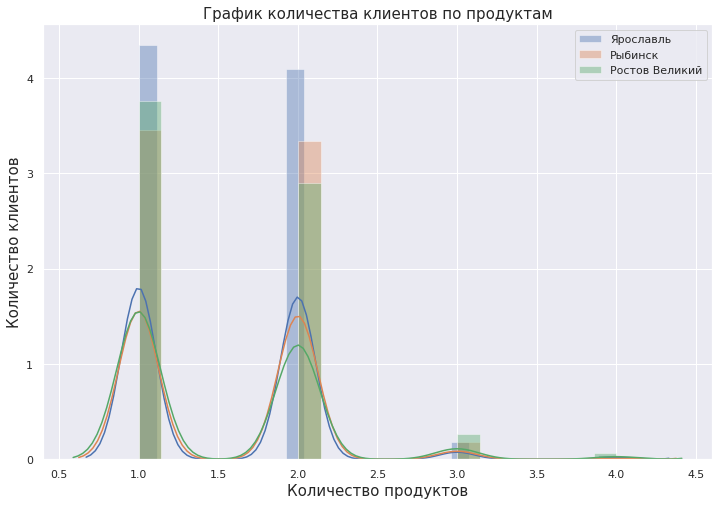

In [133]:
plt.figure(figsize=(12,8))
sns.distplot(yaroslavl_df['products'])
sns.distplot(rybinsk_df['products'])
sns.distplot(rostov_df['products'])
plt.legend(['Ярославль', 'Рыбинск', 'Ростов Великий'])
plt.title('График количества клиентов по продуктам', fontsize=15)
plt.xlabel('Количество продуктов', fontsize=15) 
plt.ylabel('Количество клиентов', fontsize=15)
plt.show()

**Вывод:** на графике наглядно видно распределение количества клиентов по количеству продуктов в городах.

#### Средние значения признаков в кагортах

In [134]:
yaroslavl_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,"5,014.00","15,733,386.11","71,375.84","15,608,450.00","15,671,341.75","15,733,506.00","15,794,909.75","15,858,396.00"
score,"5,014.00",649.67,97.02,350.00,582.00,653.00,717.00,850.00
age,"5,014.00",38.51,10.47,18.00,31.00,37.00,43.00,92.00
objects,"5,014.00",5.00,2.89,0.00,2.00,5.00,7.00,10.00
balance,"5,014.00","119,929.11","22,855.22","3,768.69","118,290.70","121,319.86","121,444.88","238,387.56"
products,"5,014.00",1.53,0.57,1.00,1.00,1.00,2.00,4.00
creditcard,"5,014.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,"5,014.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,"5,014.00","99,899.18","57,336.29",90.07,"51,399.19","99,132.31","149,295.36","199,929.17"
churn,"5,014.00",0.16,0.37,0.00,0.00,0.00,0.00,1.00


Посмотрим на количество выбросов в каждом столбце

In [135]:
def function(data,column):
    'Функция рассчета количества выбросов'
    q1=np.percentile(data[column], 25)
    q3=np.percentile(data[column], 75)
    diff=q3-q1
    min_out=q1-diff*1.5
    max_out=q3+diff*1.5

    print('Количество выбросов:',data[np.logical_or(data[column]<min_out,data[column]>max_out)][column].count(),
         '\nЗначения products выбросов '+str(column)+':',data[np.logical_or(data[column]<min_out,data[column]>max_out)]['products'].unique())

In [136]:
for name in yaroslavl_df.describe().columns:
    print(name)
    function(yaroslavl_df,name)

userid
Количество выбросов: 0 
Значения products выбросов userid: []
score
Количество выбросов: 6 
Значения products выбросов score: [1]
age
Количество выбросов: 206 
Значения products выбросов age: [1 2 3 4]
objects
Количество выбросов: 0 
Значения products выбросов objects: []
balance
Количество выбросов: 2191 
Значения products выбросов balance: [3 1 2 4]
products
Количество выбросов: 29 
Значения products выбросов products: [4]
creditcard
Количество выбросов: 0 
Значения products выбросов creditcard: []
loyalty
Количество выбросов: 0 
Значения products выбросов loyalty: []
estimated_salary
Количество выбросов: 0 
Значения products выбросов estimated_salary: []
churn
Количество выбросов: 810 
Значения products выбросов churn: [1 3 2 4]


**Вывод:**Конечно в Ярославле наибольшее количество выбросов в балансе. Есть выбросы в данных оттока клиентов.

In [137]:
rybinsk_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,"2,477.00","15,734,654.41","71,765.54","15,608,437.00","15,672,281.00","15,734,528.00","15,796,490.00","15,858,426.00"
score,"2,477.00",651.33,94.37,350.00,587.00,651.00,715.00,850.00
age,"2,477.00",38.89,10.45,18.00,32.00,37.00,44.00,88.00
objects,"2,477.00",5.03,2.86,0.00,3.00,5.00,8.00,10.00
balance,"2,477.00","119,708.47","23,227.84","12,459.19","118,433.94","119,413.64","121,056.63","250,898.09"
products,"2,477.00",1.54,0.56,1.00,1.00,2.00,2.00,4.00
creditcard,"2,477.00",0.69,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,"2,477.00",0.53,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,"2,477.00","99,440.57","57,103.68",417.41,"50,267.69","99,984.86","147,278.43","199,992.48"
churn,"2,477.00",0.17,0.37,0.00,0.00,0.00,0.00,1.00


In [138]:
for name in rybinsk_df.describe().columns:
    print(name)
    function(rybinsk_df,name)

userid
Количество выбросов: 0 
Значения products выбросов userid: []
score
Количество выбросов: 7 
Значения products выбросов score: [3 1]
age
Количество выбросов: 93 
Значения products выбросов age: [1 2 3]
objects
Количество выбросов: 0 
Значения products выбросов objects: []
balance
Количество выбросов: 1105 
Значения products выбросов balance: [1 2 3 4]
products
Количество выбросов: 7 
Значения products выбросов products: [4]
creditcard
Количество выбросов: 0 
Значения products выбросов creditcard: []
loyalty
Количество выбросов: 0 
Значения products выбросов loyalty: []
estimated_salary
Количество выбросов: 0 
Значения products выбросов estimated_salary: []
churn
Количество выбросов: 413 
Значения products выбросов churn: [1 3 2 4]


**Вывод:**наибольшее количество выбросов для Рыбинска в балансе. Это очевидно, ведь средств у каждого клиента разное количество.

In [139]:
rostov_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,"2,509.00","15,733,291.65","73,228.43","15,608,515.00","15,670,131.00","15,732,622.00","15,798,467.00","15,858,392.00"
score,"2,509.00",651.45,98.17,350.00,584.00,651.00,722.00,850.00
age,"2,509.00",39.77,10.52,18.00,32.00,38.00,45.00,84.00
objects,"2,509.00",5.01,2.94,0.00,2.00,5.00,8.00,10.00
balance,"2,509.00","119,730.12","27,022.01","27,288.43","102,800.72","119,703.10","137,560.38","214,346.96"
products,"2,509.00",1.52,0.62,1.00,1.00,1.00,2.00,4.00
creditcard,"2,509.00",0.71,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,"2,509.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00
estimated_salary,"2,509.00","101,113.44","58,263.01",11.58,"51,016.02","102,397.22","151,083.80","199,970.74"
churn,"2,509.00",0.32,0.47,0.00,0.00,0.00,1.00,1.00


In [140]:
for name in rostov_df.describe().columns:
    print(name)
    function(rostov_df,name)

userid
Количество выбросов: 0 
Значения products выбросов userid: []
score
Количество выбросов: 4 
Значения products выбросов score: [4 1 2]
age
Количество выбросов: 70 
Значения products выбросов age: [2 1 3]
objects
Количество выбросов: 0 
Значения products выбросов objects: []
balance
Количество выбросов: 33 
Значения products выбросов balance: [2 1 3]
products
Количество выбросов: 24 
Значения products выбросов products: [4]
creditcard
Количество выбросов: 0 
Значения products выбросов creditcard: []
loyalty
Количество выбросов: 0 
Значения products выбросов loyalty: []
estimated_salary
Количество выбросов: 0 
Значения products выбросов estimated_salary: []
churn
Количество выбросов: 0 
Значения products выбросов churn: []


**Вывод:**выбросы для Ростова Великого есть в возрасте-возможно клиентами являются очень возрастные люди. Небольшие выбросы в продуктах балансе.

In [141]:
df_grouped = df.groupby('city', as_index=False).mean()
df_grouped

,city,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,Ростов Великий,"15,733,291.65",651.45,39.77,5.01,"119,730.12",1.52,0.71,0.50,"101,113.44",0.32
1,Рыбинск,"15,734,654.41",651.33,38.89,5.03,"119,708.47",1.54,0.69,0.53,"99,440.57",0.17
2,Ярославль,"15,733,386.11",649.67,38.51,5.00,"119,929.11",1.53,0.71,0.52,"99,899.18",0.16


**Вывод:**Средние значения признаков в кагортах приблизительно одинаковые, за исключением коэффициента оттока в Ростове Великом. Там он выше остальных.

#### Столбчатые гистограммы и распределения признаков в кагортах

In [142]:
def replace(city):
    if city == "Ярославль":
        return 1
    elif city == "Рыбинск":
        return 2
    else:
        return 3
df['city'] = df['city'].apply(replace)

In [143]:
def replace(gender):
    if gender == 'Ж':
        return 0   
    else:
        return 1
df['gender'] = df['gender'].apply(replace)

In [144]:
distplot_columns = ['gender', 'city', 'score', 'age', 'objects', 'balance', 'creditcard', 'loyalty', 'estimated_salary', 'churn']

In [145]:
df_clients_1 = df.query('products == 1').drop('products', axis = 1)
df_clients_2 = df.query('products == 2').drop('products', axis = 1)
df_clients_3 = df.query('products == 3').drop('products', axis = 1)
df_clients_4 = df.query('products == 4').drop('products', axis = 1)

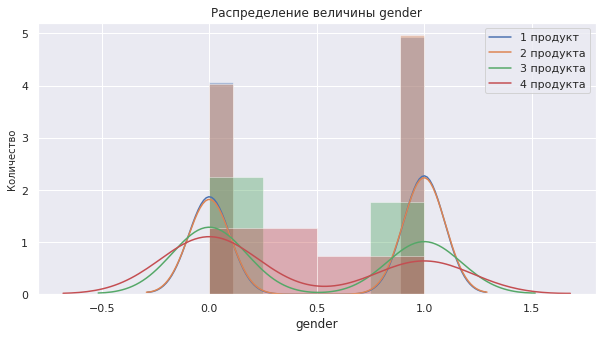

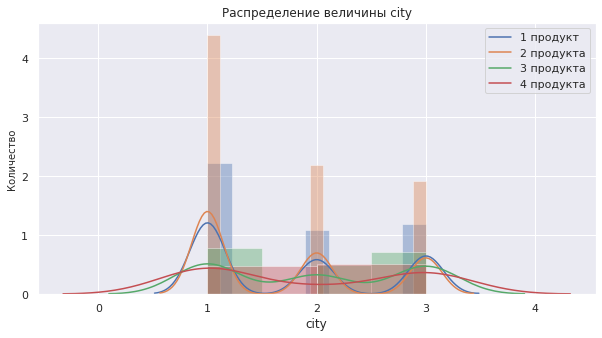

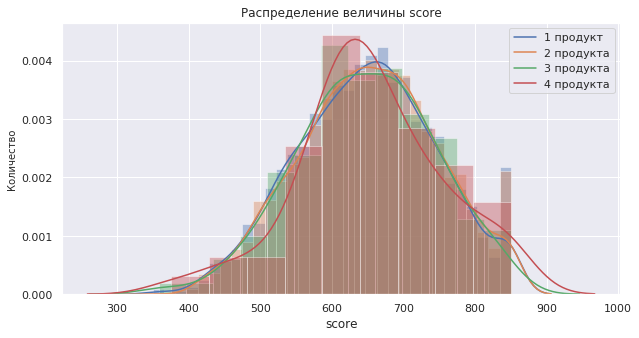

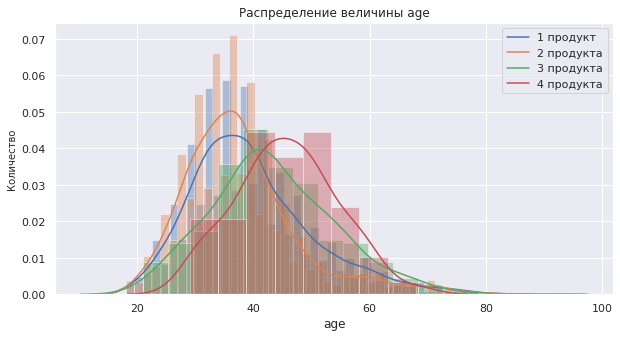

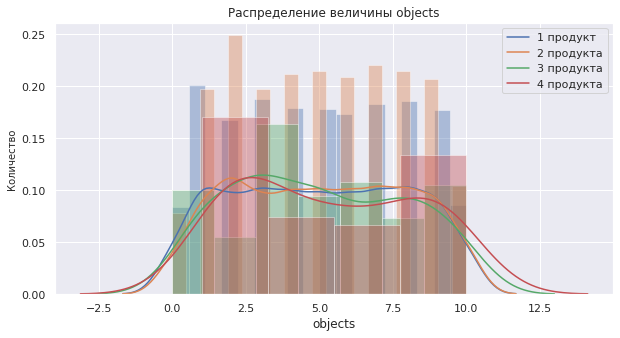

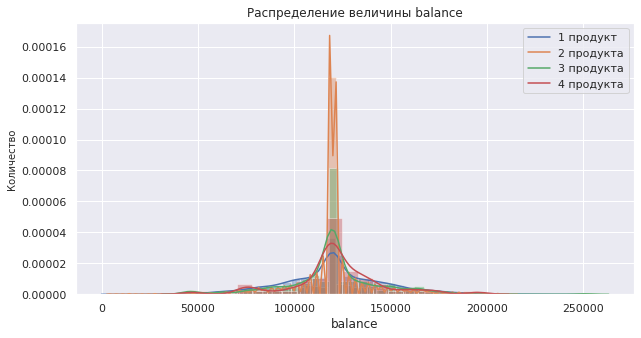

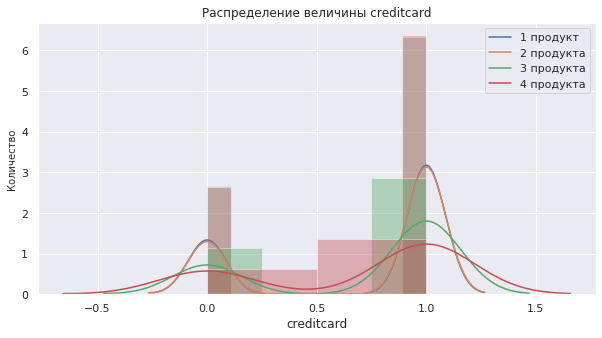

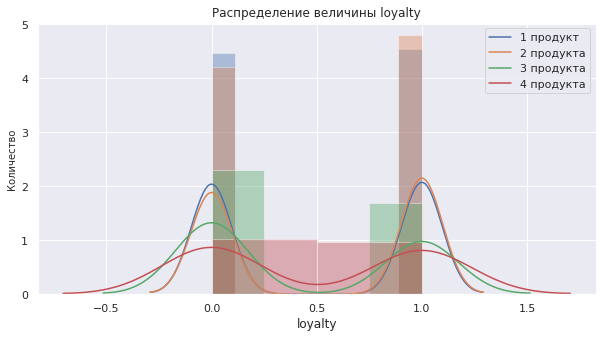

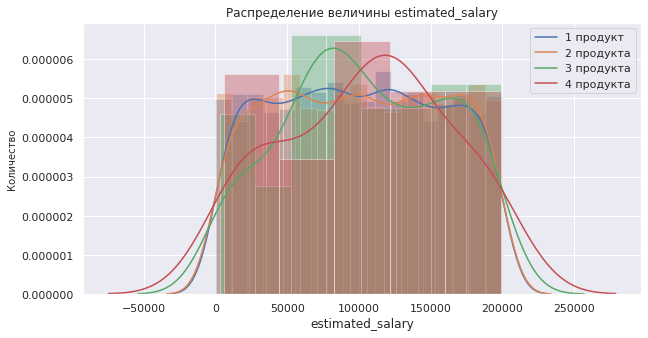

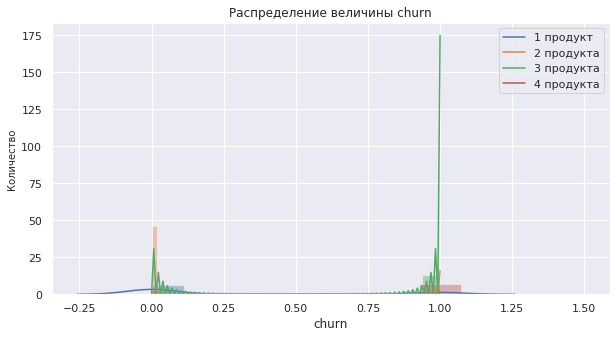

In [146]:
for i in distplot_columns:
    
    plt.figure(figsize=(10,5))
    
    sns.distplot(df_clients_1[i],  kde_kws = {'label':'df_clients_1'})
    
    sns.distplot(df_clients_2[i],  kde_kws = {'label':'df_clients_2'})
    
    sns.distplot(df_clients_3[i],  kde_kws = {'label':'df_clients_3'})
    
    sns.distplot(df_clients_4[i],  kde_kws = {'label':'df_clients_4'})
    
    plt.legend(['1 продукт', '2 продукта', '3 продукта', '4 продукта'])
    
    plt.title('Распределение величины {}'.format(i))
    
    plt.ylabel('Количество', fontsize=10)
    
    plt.show()

**Вывод:**

   -Почти все пользователи с количеством продуктов 3 и 4 ушли.
   
   -Пользователи с количеством продуктов 2 уходят реже всего.
   
   -*estimated_salary* рассчитывается на основе данных со стороны (пенсионный фонд, налоговые выкладки).Наибольшие у клиентов с 3 и 4 продуктами.
    
   -*balance* и score распределен примерно одинаково.
   
   -Лояльность клиентов одинакова.
   
   -У мужчин продуктов больше.
   
   -В Ярославле больше всех клиентов с 1 продуктом.

#### Mатрица корреляций

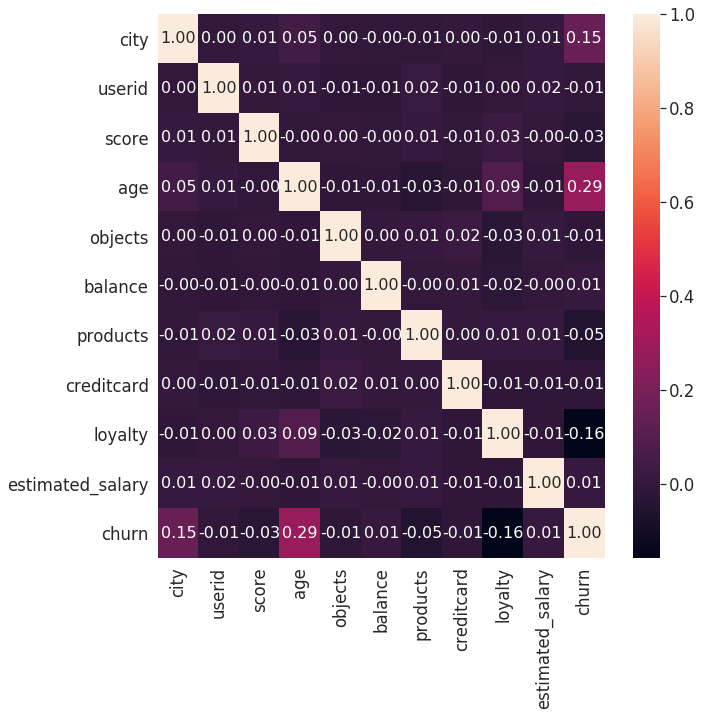

In [147]:
cm=df[df_grouped.columns].corr()
sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='.2f',annot_kws={"size": 16});

**Вывод:**В данных заметных корреляций не наблюдается

### Сегментировать пользователей по количеству потребляемых продуктов

#### Сравним кластеры по средним значениям имеющихся метрик

Разобъем данные на обучающую и валидационную выборки функцией train_test_split()

In [148]:
X = df.drop(['products'], axis = 1)
y = df['products']

In [149]:
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
scaler=StandardScaler()
scaler.fit(X_train)
X_train_sc=scaler.transform(X_train)
X_test_sc=scaler.transform(X_test)

In [150]:
df_st = scaler.fit_transform(df.drop('products', axis=1))

In [151]:
linked = linkage(df_st, method = 'ward')

In [152]:
dendrogram

<function scipy.cluster.hierarchy.dendrogram(Z, p=30, truncate_mode=None, color_threshold=None, get_leaves=True, orientation='top', labels=None, count_sort=False, distance_sort=False, show_leaf_counts=True, no_plot=False, no_labels=False, leaf_font_size=None, leaf_rotation=None, leaf_label_func=None, show_contracted=False, link_color_func=None, ax=None, above_threshold_color='b')>

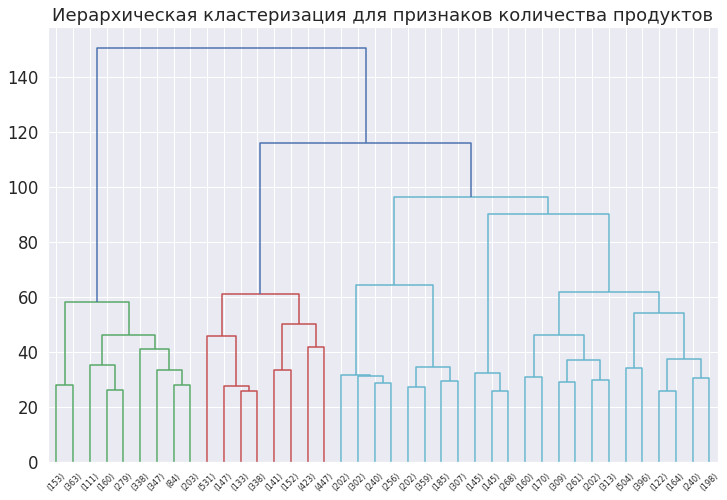

In [153]:
plt.figure(figsize=(12, 8))  
dendrogram(linked, p=40, leaf_rotation=45, truncate_mode='lastp')
plt.title('Иерархическая кластеризация для признаков количества продуктов')
plt.show()

**Вывод:**На дендрограмме видим 3 больших кластера.

Посчитаем, сколько в каждом кластере записей:

In [154]:
km = KMeans(n_clusters=3, random_state=0)
label= km.fit_predict(df_st)
df['clusters'] = label

In [155]:
df.groupby('clusters').agg({'userid': 'count'})

,userid
clusters,
0,3545
1,2039
2,4416


#### Средние значения признаков кластеров

In [156]:
df.groupby('clusters').mean()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
clusters,,,,,,,,,,,,
0,"15,733,935.99",648.86,1.67,0.57,35.45,5.13,"120,172.34",1.56,0.71,0.00,"100,338.85",0.00
1,"15,732,793.16",645.45,2.00,0.44,44.87,4.94,"120,455.04",1.47,0.70,0.36,"101,471.15",1.00
2,"15,733,876.22",654.21,1.70,0.58,38.96,4.96,"119,254.20",1.54,0.71,1.00,"99,253.06",0.00


**Вывод:**Можно заметить некоторые отличия кластеров:
        
        Для 0 кластера характерно наибольшее среднее количество объектов при молодом возрасте. Клиенты 2 кластера - активные клиенты. Весь 1 кластер из Ростова Великого c высоким средним возрастом.

**Распределение признаков кластеров**

Для признаков вида 0/1 возьмем countplot

In [157]:
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn',
       'clusters'],
      dtype='object')

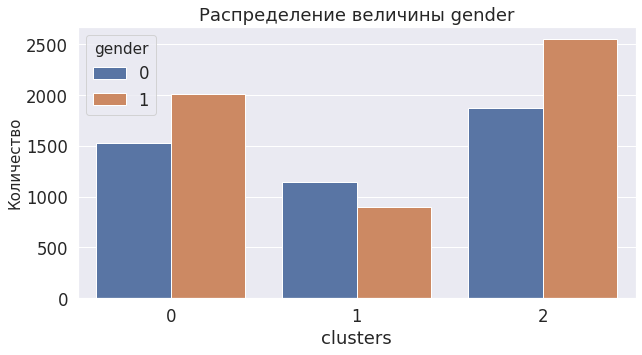

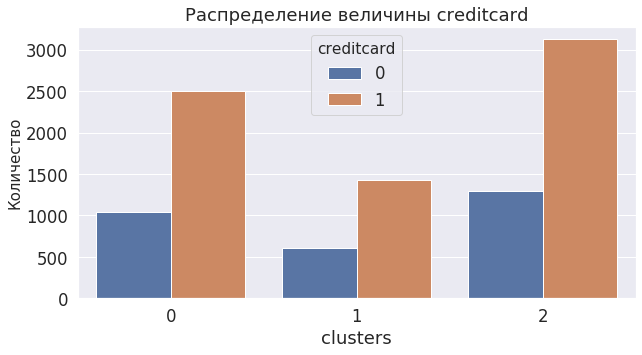

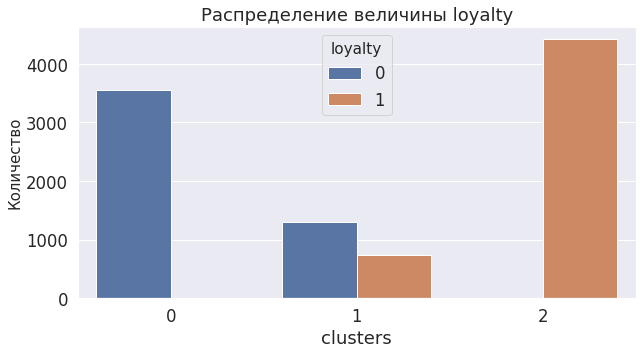

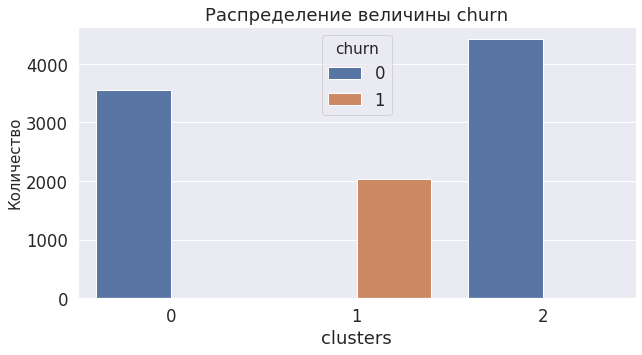

In [158]:
for f in ['gender', 'creditcard', 'loyalty', 
       'churn']:
    sns.countplot(data=df, x='clusters', hue=f)
    
    plt.title('Распределение величины {}'.format(f))
    
    plt.ylabel('Количество', fontsize=15)
    plt.show()

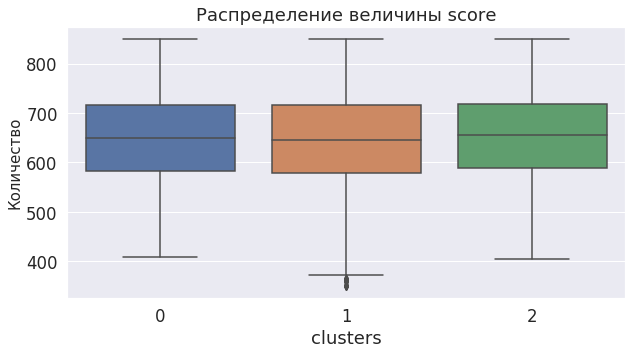

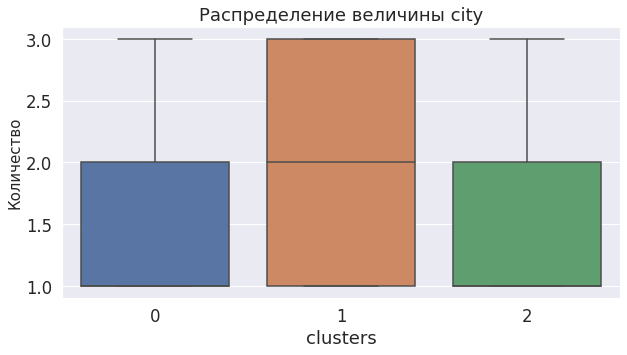

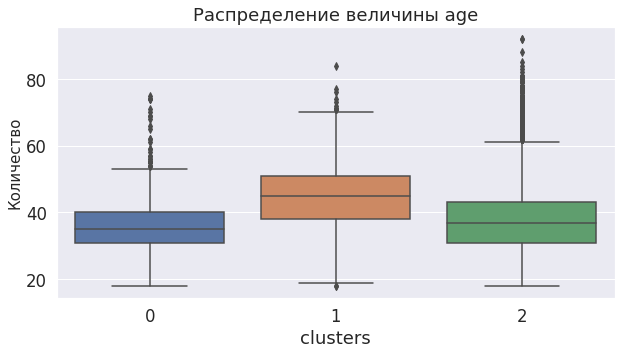

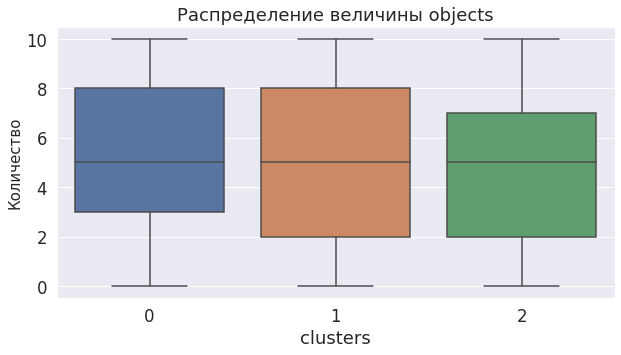

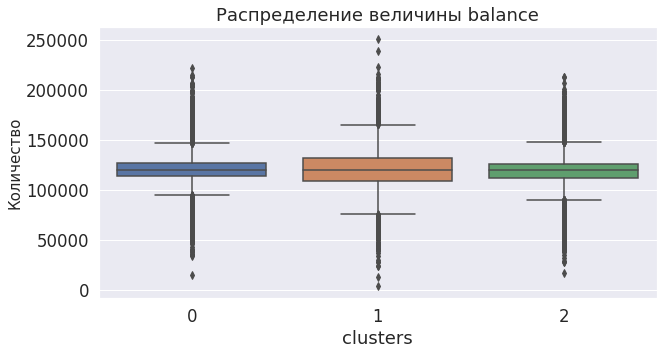

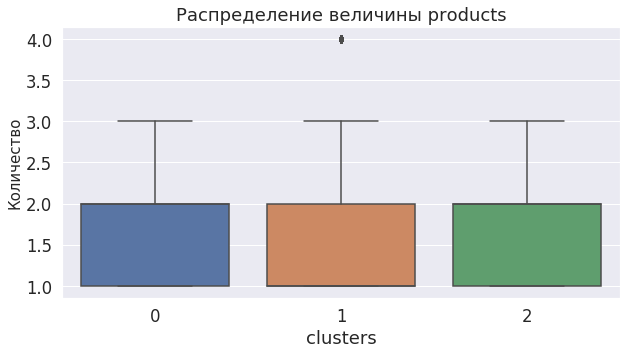

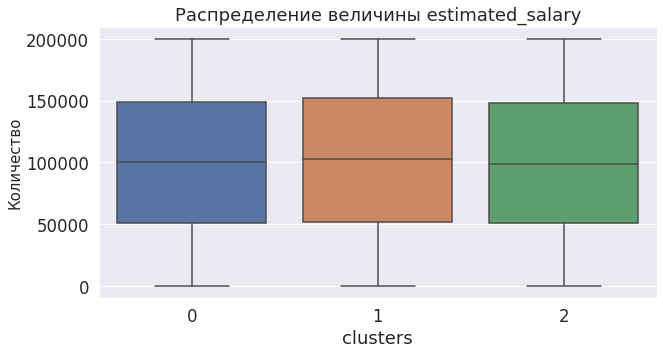

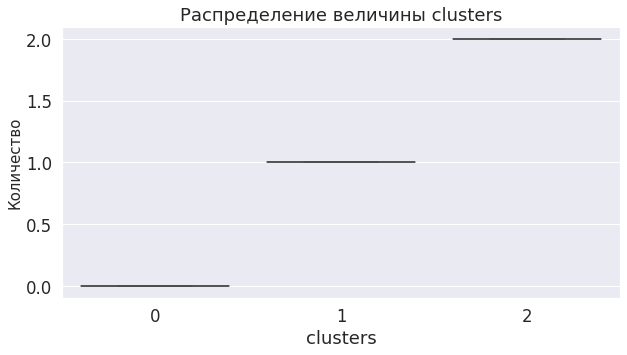

In [159]:
for f in ['score', 'city', 'age', 'objects', 'balance',
       'products', 'estimated_salary',
       'clusters']:
    sns.boxplot(data=df, x='clusters', y=f)
    plt.title('Распределение величины {}'.format(f))
    
    plt.ylabel('Количество', fontsize=15)
    plt.show()

**Вывод:** 
    Графики говорят, что:
        
        Больше всего мужчин во 2 кластере.
        В нём же наибольшее количество кредитных карт, а меньше всех в 1.
        2-й кластер имеет наиболее лояльных клиентов. Наименее лояльные- в 0 кластере.
        Больше всех отток в 1 , а во2 - БОЛЬШЕ остаются.
        
        Величина кредитного рейтинга во всех кластерах приблизительно одинаковая.
        1-й кластер расположен в одном городе.
        В 1 кластере наибольший средний возраст клиентов, а у 2-го - большие выбросы в сторону увеличения.
        Количество объектов и балансы карт у трёх кластеров ориентировочно одинаковые, но у балансов большие усы.

### Проверить статистические гипотезы

#### Проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Для применения t-критерия Стьюдента необходимо, чтобы исходные данные имели нормальное распределение. Также имеет значение равенство дисперсий (распределения) сравниваемых групп. При неравных дисперсиях применяется t-критерий в модификации Уэлча.

*Сформулируем гипотезы:*

**h0:** доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним одинаковые.

**h1:** доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним различны.

Проверим данные на нормальность

In [160]:
df_products_1=df.query("products==1")
df_products_2=df.query("products==2")

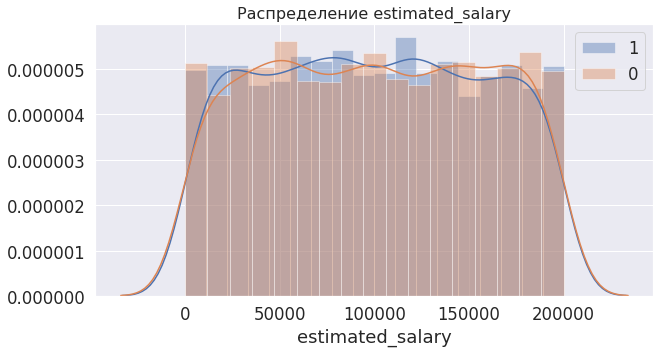

In [161]:
sns.distplot(df_products_1['estimated_salary'],label='1')
sns.distplot(df_products_2['estimated_salary'],label='0')
plt.title('Распределение estimated_salary',fontsize=16)
plt.legend()
plt.show()

**Вывод:**Mожем считать, что данные распределены нормально, поэтому проведем t-test.

In [162]:
alpha=0.05

print('Дисперсия с 1 продуктом :',df_products_1['estimated_salary'].var())
print('Дисперсия с 2 продуктами:',df_products_2['estimated_salary'].var())

Дисперсия с 1 продуктом : 3290585635.088143
Дисперсия с 2 продуктами: 3339776562.810999


**Вывод:**Дисперсии приблизительно равны

In [163]:
results = st.ttest_ind(
    df_products_1['estimated_salary'], 
    df_products_2['estimated_salary'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.41047183624949335
Не получилось отвергнуть нулевую гипотезу


**Вывод:** дисперсии клиентов с 1-м и 2-мя продуктами равны и средние доходы равны.

#### Сформулировать и проверить статистическую гипотезу относительно представленных данных.

*Сформулируем гипотезы:*

Проверим гипотезу различия score между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.¶

**h0:** баллы кредитного скоринга клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним одинаковые.

**h1:** баллы кредитного скоринга клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним различные.

Проверим данные на нормальность

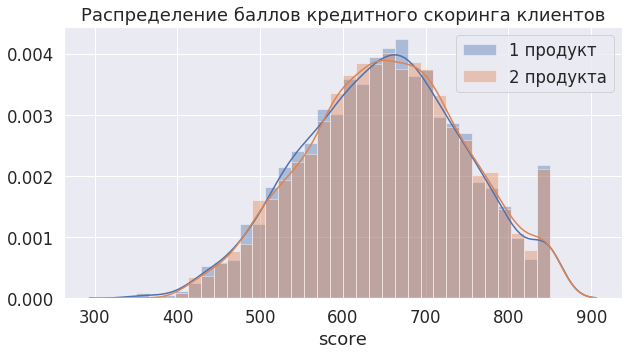

In [164]:
sns.distplot(df_products_1['score'],label='1 продукт')
sns.distplot(df_products_2['score'],label='2 продукта')
plt.title('Распределение баллов кредитного скоринга клиентов')
plt.legend()
plt.show()

**Вывод:** Данные можно считать распределенными нормально.

In [165]:
alpha=0.05

print('Дисперсия с 1 продуктом :',df_products_1['score'].var())
print('Дисперсия с 2 продуктами:',df_products_2['score'].var())

Дисперсия с 1 продуктом : 9448.561204965317
Дисперсия с 2 продуктами: 9228.836045084605


**Вывод:**Дисперсии равны

In [166]:
results = st.ttest_ind(
     df_products_1['score'], 
     df_products_2['score'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1191143371309672
Не получилось отвергнуть нулевую гипотезу


**Вывод:** дисперсии клиентов с 1-м и 2-мя продуктами равны и средние баллы кредитного скоринга клиентов равны.

### Общий вывод:

   1. Произвели заполнение пропущенных данных balance по принадлежности пользователя к городу и полу. Уменьшен регистр у названий слобцов.
   2. Построили гистограммы и распределения признаков в кагортах, имеем следующие результаты:
   
      -Почти все пользователи с количеством продуктов 3 и 4 ушли.
    
      -Пользователи с количеством продуктов 2 уходят реже всего.
        
      -*estimated_salary* рассчитывается на основе данных со стороны (пенсионный фонд, налоговые выкладки).Наибольшие у клиентов с 3 и 4 продуктами.
    
      -*balance* и score распределен примерно одинаково.
        
      -Лояльность клиентов одинакова.
    
      -У мужчин продуктов больше.
        
      -В Ярославле больше всех клиентов с 1 продуктом.
      
   3. Проанализировали кластеры:
      
      Больше всего мужчин во 2 кластере.
      
      В нём же наибольшее количество кредитных карт, а меньше всех в 1.
      
      2-й кластер имеет наиболее лояльных клиентов. Наименее лояльные- в 0 кластере.
      
      Больше всех отток в 1 , а во2 - БОЛЬШЕ остаются.
      

      Величина кредитного рейтинга во всех кластерах приблизительно одинаковая.
      
      1-й кластер расположен в одном городе.
      
      В 1 кластере наибольший средний возраст клиентов, а у 2-го - большие выбросы в сторону увеличения.
      
      Количество объектов и балансы карт у трёх кластеров ориентировочно одинаковые, но у балансов большие усы.

   4. Проверили проверку гипотез и применили t-критерий Стьюдента:
   
   **Гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.**
   
   -*Нулевая гипотеза* - доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним одинаковые.
     
   -*Альтернативная гипотеза* - доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним различны.
   
    Мы не смогли отвергнуть нулевую гипотезу. Дисперсии клиентов с 1-м и 2-мя продуктами равны и средние доходы равны.
    
   **Гипотезу различия score между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.**

   -*Нулевая гипотеза* -  баллы кредитного скоринга клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним одинаковые.
   
   -*Альтернативная гипотеза* - баллы кредитного скоринга клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним различные.
   
    Не получилось отвергнуть нулевую гипотезу. Дисперсии клиентов с 1-м и 2-мя продуктами равны и средние баллы кредитного скоринга клиентов равны.


Ссылка на презентацию: https://disk.yandex.ru/i/jeqTzk9RTtYdwA